Trains on data with tumor purity of 10% and expected coverage of 30. Only positions with >=3 clips are considered when making  windows around them. There are 3 categories: start of deletions, end of deletions and insertions, all are somatic. I split the dataset in 3000 training, 1200 validation and 1289 test points. The test accuracy is 95%. 

## Load dependences and setting output configuration

In [283]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\sonja\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load data from npy files

In [285]:
datapath = 'F:/1_GTCG/data/TrainingData_290518_10pc_TP.tar/TrainingData_290518_10pc_TP/somatic.npy/' 
#germline_cube = np.load(datapath + 'germline.npy')
somatic_cube = np.load(datapath + 'somatic.npy')
datapath = 'F:/1_GTCG/data/20_04_18/unpacked/' 
noSV_cube = np.load(datapath + 'noSV.npy')
datapath = 'F:/1_GTCG/data/TrainingData_290518_10pc_TP.tar/TrainingData_290518_10pc_TP/labels/somatic_label.npy/'
#germline_labels = np.load(datapath + 'germline_label.npy')
somatic_labels = np.load(datapath + 'somatic_label.npy')
datapath = 'F:/1_GTCG/data/20_04_18/unpacked/' 
noSV_labels = np.load(datapath + 'noSV_label.npy')

In [ ]:
def enrich_germline_labels(labels):
    for i in range (0, labels.shape[0]):
        labels[i] = 'g_' + labels[i]

In [ ]:
#enrich_germline_labels(germline_labels)

### Find  the indexes that split the categories

In [286]:
def find_splitting_indices(labels):
    for i in range (0, labels.shape[0] - 1):
        if (labels[i] != labels[i+1]):
            print(i , ': ', labels[i] , labels[i+1] )        

In [ ]:
#find_splitting_indices(germline_labels)

In [287]:
find_splitting_indices(somatic_labels)

1855 :  DEL_start DEL_end
3665 :  DEL_end INS_pos


In [ ]:
#find_splitting_indices(noSV_labels)

### Check sizes of arrays

In [ ]:
#qube_size = germline_cube.shape[0]
                            
#germline_cube.shape

In [288]:
somatic_cube.shape

(5489, 22, 50)

In [ ]:
#germline_labels.shape

In [289]:
somatic_labels.shape

(5489,)

In [ ]:
#print(germline_cube[:,2][1])

In [290]:
noSV_cube.shape

(20717, 22, 50)

## Split into training, validation and test datasets

From the germline set 

-- there will be 2000 training, 1000 validation and 1229 test windows for ´start of deletions´.

-- there will be 2000 training, 1000 validation and 1272 test windows for ´end of deletions´. 

For insertions the numbers are 8000, 2000, 1861. 
 

In [291]:

s_del_st = 1855
s_del_end = 3665

how many of each category should go in training set and how many in validation. The rest is in test set

In [292]:
n_train = 1000
n_val = 400

X_train_germline = np.concatenate((germline_cube[0:n_train], germline_cube[g_del_st:g_del_st+n_train],  germline_cube[g_del_end:g_del_end+2*n_train]),axis=0)
y_train_germline = np.concatenate((germline_labels[0:n_train], germline_labels[g_del_st:g_del_st+n_train],  germline_labels[g_del_end:g_del_end+2*n_train]),axis=0)
X_val_germline = np.concatenate((germline_cube[n_train:n_train + n_val], germline_cube[g_del_st+n_train:g_del_st+n_train+n_val],  germline_cube[g_del_end+2*n_train:g_del_end+2*n_train+2*n_val]),axis=0)
y_val_germline = np.concatenate((germline_labels[n_train:n_train + n_val], germline_labels[g_del_st+n_train:g_del_st+n_train+n_val],  germline_labels[g_del_end+2*n_train:g_del_end+2*n_train+2*n_val]),axis=0)
X_test_germline = np.concatenate((germline_cube[n_train + n_val:g_del_st], germline_cube[g_del_st+n_train+n_val:g_del_end],  germline_cube[g_del_end+2*n_train+2*n_val:]),axis=0)
y_test_germline = np.concatenate((germline_labels[n_train + n_val:g_del_st], germline_labels[g_del_st+n_train+n_val:g_del_end],  germline_labels[g_del_end+2*n_train+2*n_val:]),axis=0)

Repeat the same for the somatic

In [293]:
X_train_somatic = np.concatenate((somatic_cube[0:n_train], somatic_cube[s_del_st:s_del_st+n_train],  somatic_cube[s_del_end:s_del_end+n_train]),axis=0)
y_train_somatic = np.concatenate((somatic_labels[0:n_train], somatic_labels[s_del_st:s_del_st+n_train],  somatic_labels[s_del_end:s_del_end+n_train]),axis=0)
X_val_somatic = np.concatenate((somatic_cube[n_train:n_train + n_val], somatic_cube[s_del_st+n_train:s_del_st+n_train+n_val],  somatic_cube[s_del_end+n_train:s_del_end+n_train+n_val]),axis=0)
y_val_somatic = np.concatenate((somatic_labels[n_train:n_train + n_val], somatic_labels[s_del_st+n_train:s_del_st+n_train+n_val],  somatic_labels[s_del_end+n_train:s_del_end+n_train+n_val]),axis=0)
X_test_somatic = np.concatenate((somatic_cube[n_train + n_val:s_del_st], somatic_cube[s_del_st+n_train+n_val:s_del_end],  somatic_cube[s_del_end+n_train+n_val:]),axis=0)
y_test_somatic = np.concatenate((somatic_labels[n_train + n_val:s_del_st], somatic_labels[s_del_st+n_train+n_val:s_del_end],  somatic_labels[s_del_end+n_train+n_val:]) ,axis=0)

Repeat the same for noSV

In [294]:
X_train_noSV= noSV_cube[0:2*n_train]
y_train_noSV =noSV_labels[0:2*n_train] 
X_val_noSV= noSV_cube[2*n_train:2*n_train+2*n_val]
y_val_noSV =noSV_labels[2*n_train:2*n_train+2*n_val] 
X_test_noSV= noSV_cube[2*n_train+2*n_val:2*n_train+4*n_val]
y_test_noSV =noSV_labels[2*n_train+2*n_val:2*n_train+4*n_val] 

Concatenate the previous germline and somatic datasets.

In [295]:
X_train = np.concatenate(( X_train_somatic, X_train_noSV), axis =0)
X_val = np.concatenate(( X_val_somatic, X_val_noSV), axis =0)
X_test = np.concatenate(( X_test_somatic, X_test_noSV), axis =0)
y_train = np.concatenate(( y_train_somatic, y_train_noSV), axis =0)
y_val = np.concatenate(( y_val_somatic, y_val_noSV), axis =0)
y_test = np.concatenate(( y_test_somatic, y_test_noSV), axis =0)

### Number of training, validation and test windows

In [296]:
X_train.shape

(5000, 22, 50)

In [297]:
X_val.shape

(2000, 22, 50)

In [298]:
X_test.shape

(2089, 22, 50)

In [299]:
number_channels = X_train.shape[1]
number_channels

22

In [ ]:
maxy_Xtrain = numpy.zeros(shape=(number_channels))

for j in range (0, number_channels):
    maxy_Xtrain[j] = np.amax(X_train[:,j])
    print(maxy_Xtrain[j])


## Normalize data using the reads coverage as parameter

In [300]:
coverage_normal = np.median(X_train[:, 11, :]) #the median of the coverage in the normal cells
coverage_normal

30.0

In [301]:
coverage_tumor = np.median(X_train[:, 0, :]) #the median of the coverage in the normal cells
coverage_tumor
coverage = coverage_tumor

In [302]:
expected_distance = 150
ones = np.ones(X_train.shape[2])*expected_distance*coverage

In [ ]:
ones

In [303]:
def normalize(X):       
    for i in range (0, len(X)):                    
        for k in [3,4,5,6,12,15,16,17]:#the distance channels
            X[i][k] = np.minimum(X[i][k], ones)
            X[i][k] = np.divide(X[i][k], expected_distance)            
        for j in range(0,number_channels):                                                                                            
            X[i][j] = np.divide(X[i][j], coverage)*100 
normalize(X_train)
normalize(X_val)
normalize(X_test)

In [304]:
def eliminate_noise_chanels(X):
    return np.delete(X, [3, 6, 12, 17], axis=1)
    

In [305]:
X_train = eliminate_noise_chanels(X_train)
X_val = eliminate_noise_chanels(X_val)
X_test = eliminate_noise_chanels(X_test)

In [306]:
X_train.shape

(5000, 18, 50)

In [307]:
number_channels = X_train.shape[1]
number_channels

18

## Plots several  windows from the somatic SV category

In [308]:
n_windows = 30
label = ["None"] * number_channels

In [309]:
label[0] = "tumor:coverage"
label[1] = "tumor:#left clipped reads"
label[2] = "tumor:#right clipped reads"
label[3] = "tumor:sum of distances to mates for forward reads"
label[4] = "tumor:sum of distances to mates for reverse reads"
label[5] = "tumor:#split reads left split"
label[6] = "tumor:#split reads right split"
label[7] = "tumor:sum of gaps for left split reads"
label[8] = "tumor: sum of gaps for right split reads"

In [310]:
label[0+9] = "normal:coverage"
label[1+9] = "normal:#left clipped reads"
label[2+9] = "normal:#right clipped reads"
label[3+9] = "normal:sum of distances to mates for forward reads"
label[4+9] = "normal:sum of distances to mates for reverse reads"
label[5+9] = "normal:#split reads left split"
label[6+9] = "normal:#split reads right split"
label[7+9] = "normal:sum of gaps for left split reads"
label[8+9] = "normal: sum of gaps for right split reads"

In [311]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 5):
        print(y_train[i], 'id:', i)
        print('id:', i)
        for j in range (0, number_channels):   
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 8:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_train[i][j]]  
            #plt.ylim([100,700])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_train[i][j]]  
            if j>8:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 9])
            else:
                plt.plot(Z, label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})    
        plt.show()

DEL_start id: 985
id: 985


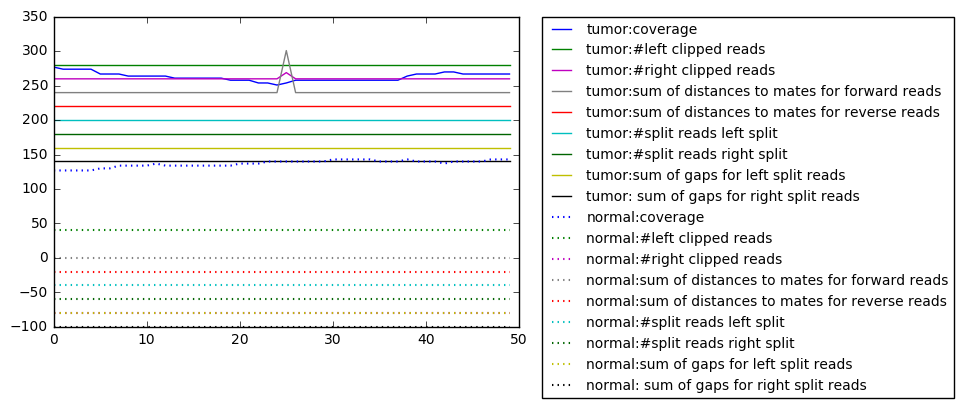

DEL_start id: 990
id: 990


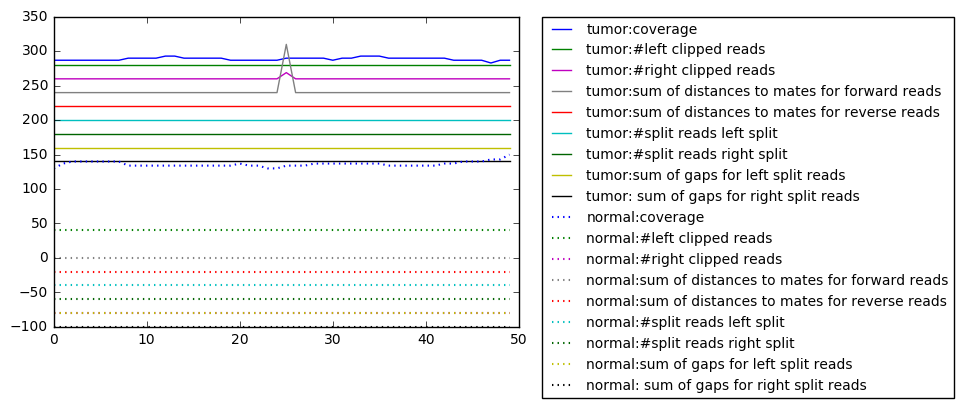

DEL_start id: 995
id: 995


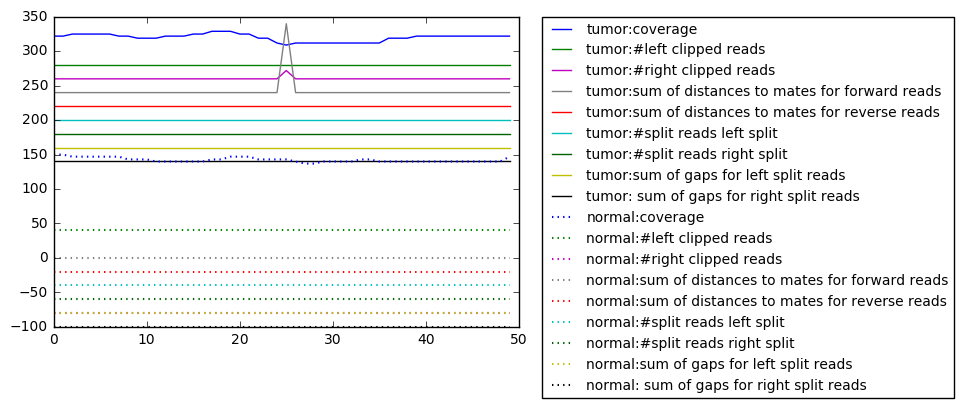

DEL_start id: 1000
id: 1000


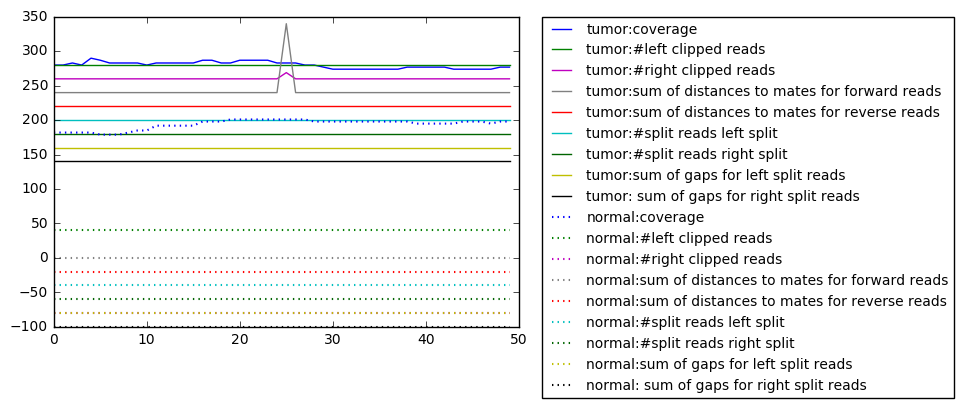

DEL_end id: 1005
id: 1005


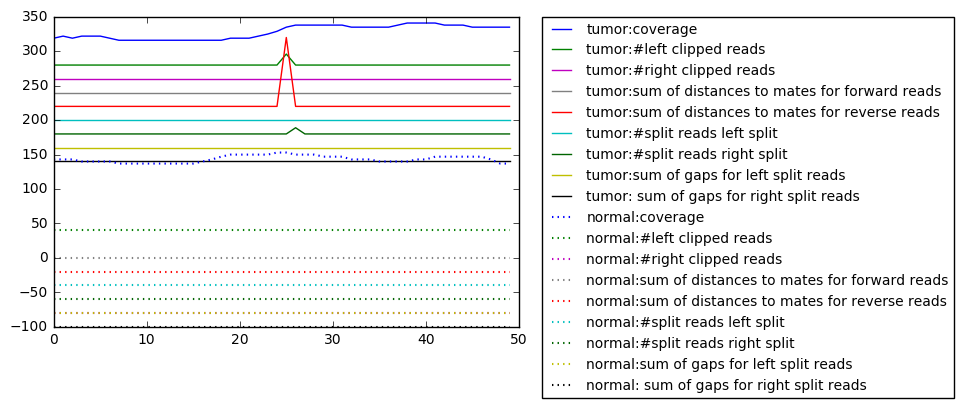

DEL_end id: 1010
id: 1010


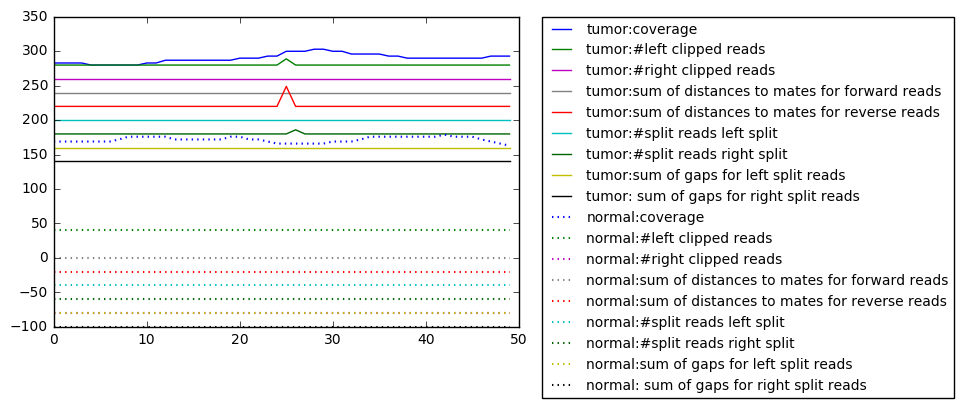

In [312]:
start_window = n_train -15
plot_channels(start_window, n_windows)

INS_pos id: 2840
id: 2840


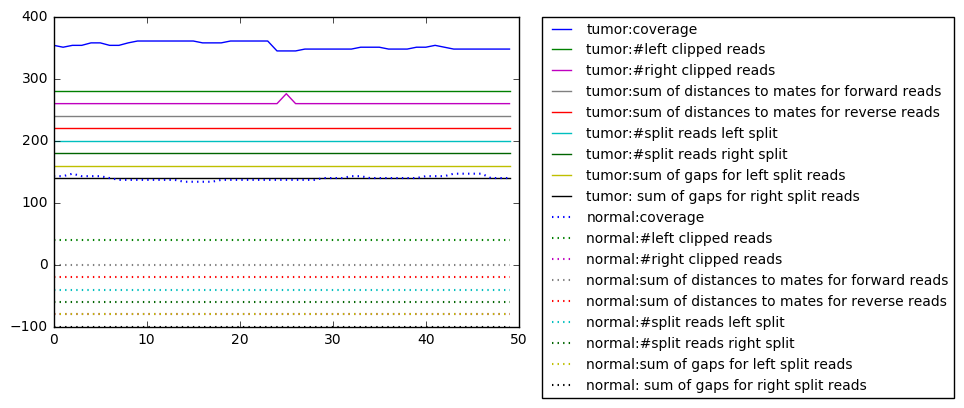

INS_pos id: 2845
id: 2845


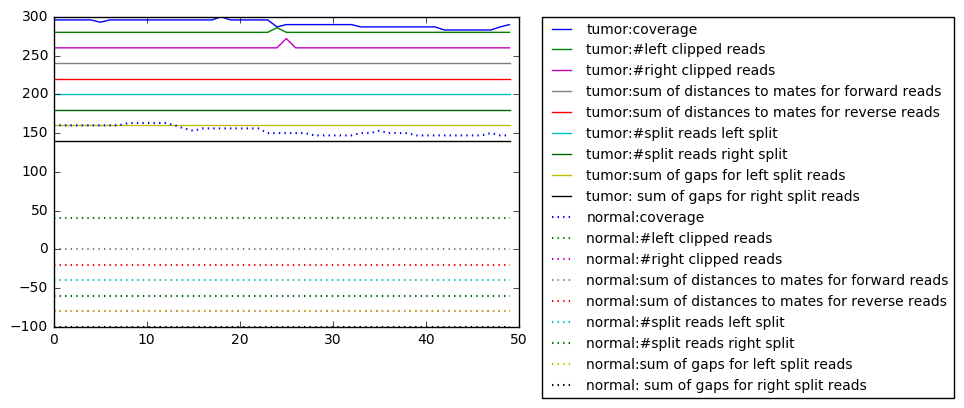

INS_pos id: 2850
id: 2850


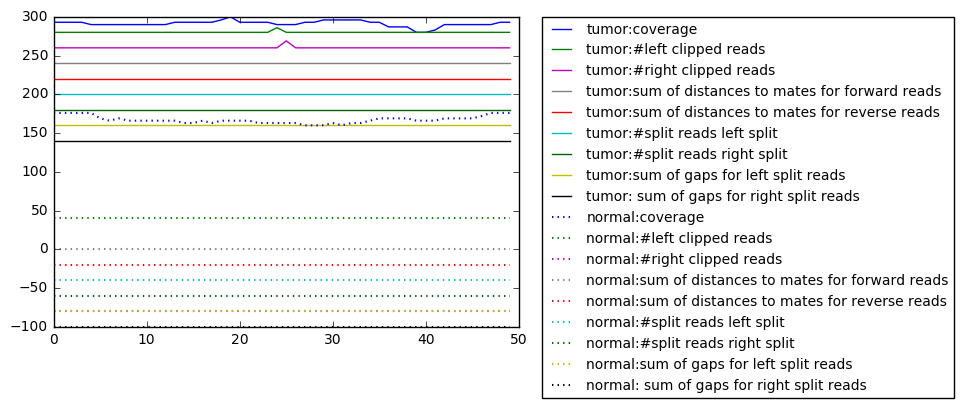

INS_pos id: 2855
id: 2855


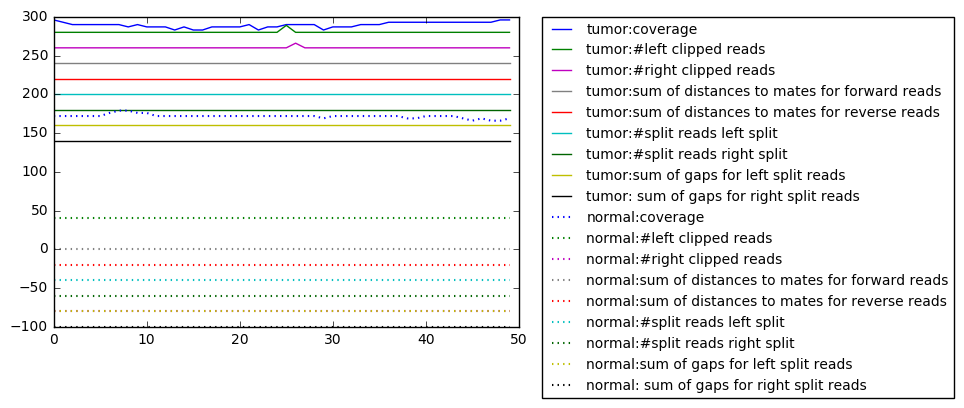

INS_pos id: 2860
id: 2860


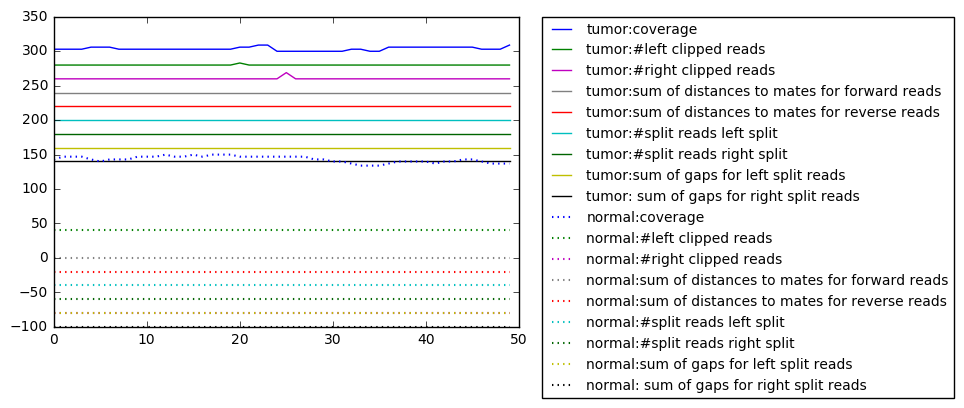

INS_pos id: 2865
id: 2865


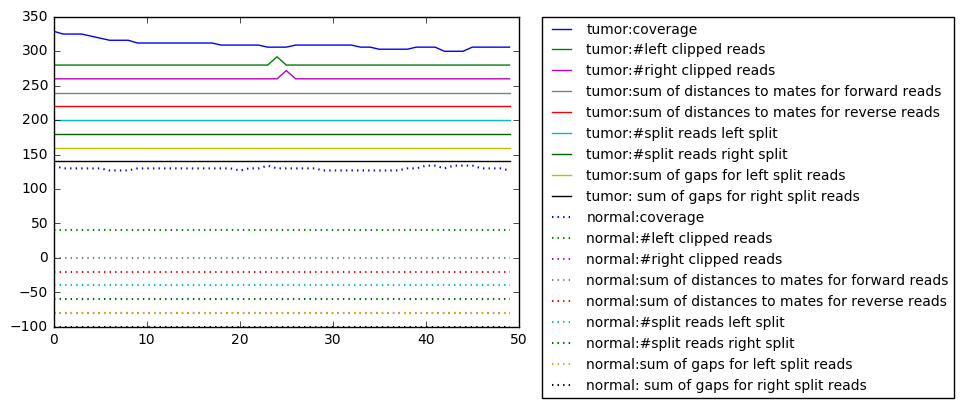

In [313]:
start_window =n_train + s_del_st-15
plot_channels(start_window, n_windows)

noSV id: 4000
id: 4000


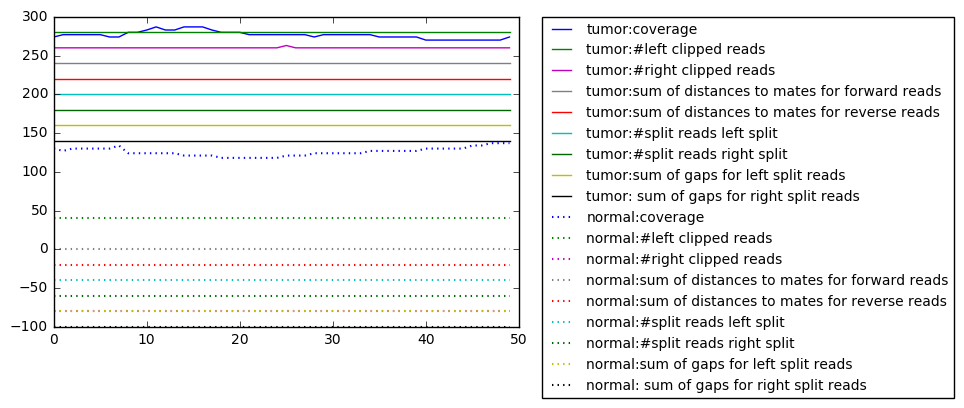

noSV id: 4005
id: 4005


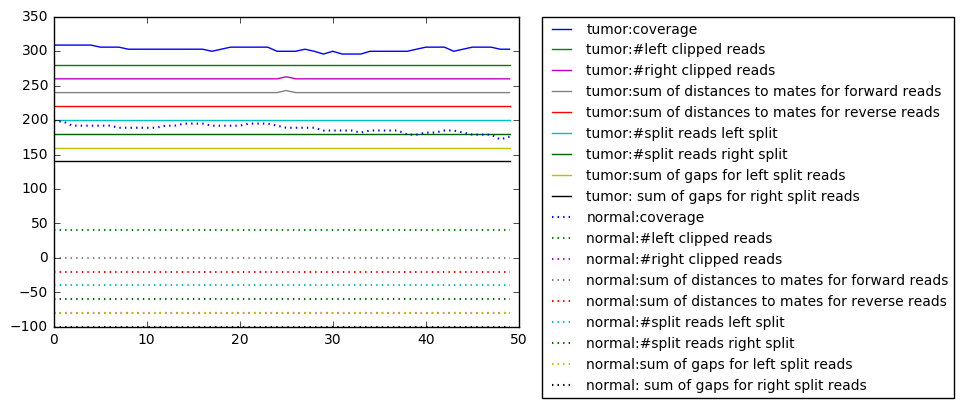

noSV id: 4010
id: 4010


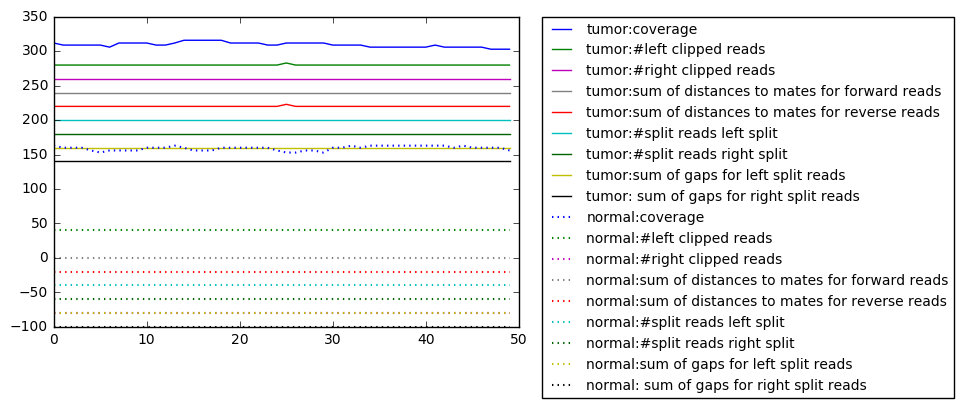

noSV id: 4015
id: 4015


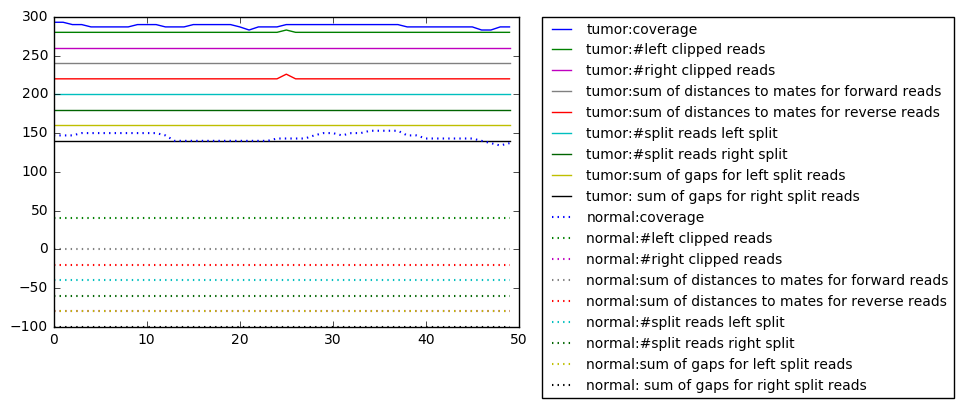

noSV id: 4020
id: 4020


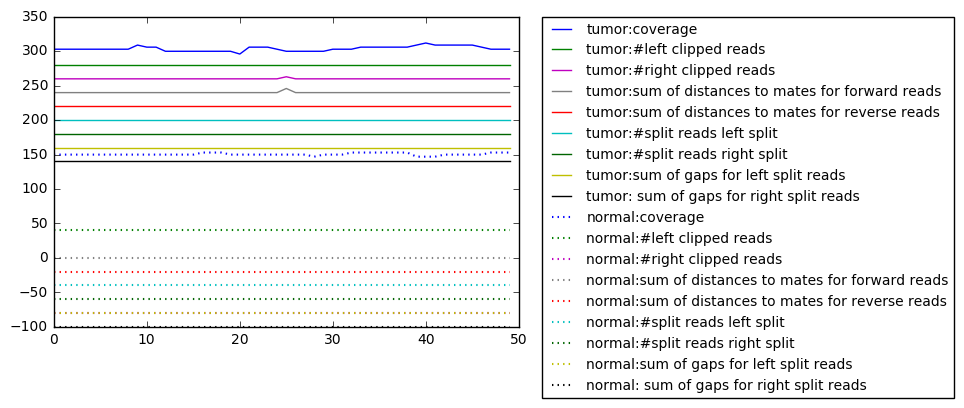

noSV id: 4025
id: 4025


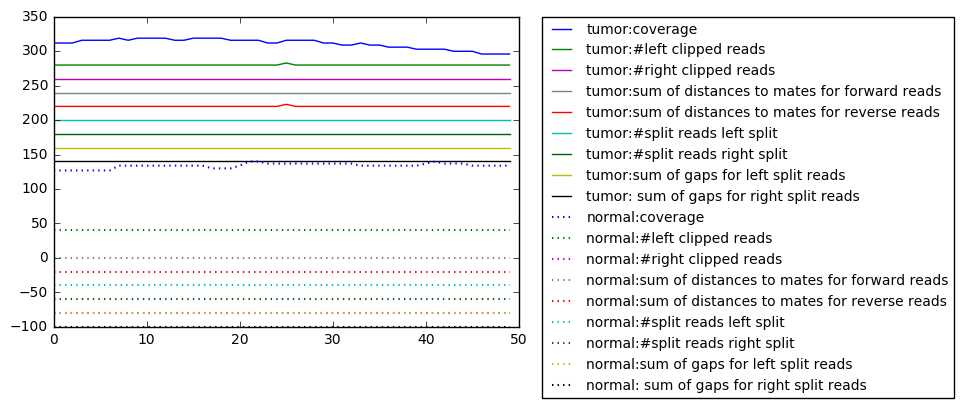

In [314]:
start_window =4000
plot_channels(start_window, n_windows)

   
## Transposes every window in X, to comply to McFly format

In [315]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

18


## Prepare the labels in McFly format

In [316]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

{'INS_pos': 0, 'DEL_end': 1, 'DEL_start': 2, 'noSV': 3}


In [317]:
y_test_binary

array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.]])

In [318]:
y_val_binary

array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.]])

In [319]:
X_train.shape

(5000, 50, 18)

## Generate neural networks architectures

In [320]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [321]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

In [322]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 1,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=1,
                                  cnn_min_fc_nodes=7, 
                                  cnn_max_fc_nodes=10,
                                  low_lr=2, high_lr=2)

Wall time: 789 ms


In [323]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'regularization_rate': 0.00033700422705314106, 'fc_hidden_nodes': 8, 'filters': array([57]), 'learning_rate': 0.01}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_166 (Bat (None, 50, 18)            72        
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 50, 57)            3135      
_________________________________________________________________
batch_normalization_167 (Bat (None, 50, 57)            228       
_________________________________________________________________
activation_166 (Activation)  (None, 50, 57)            0         
_________________________________________________________________
flatten_56 (Flatten)         (None, 2850)              0         
_________________________________________________________________
dense_111 (Dense)            (None, 8)                 22808     
_________________________

## Train the networks

In [324]:
train_set_size = X_train.shape[0]
train_set_size

5000

In [325]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=5, 
                                                                                  subset_size=train_set_size,
                                                                                  verbose=True)

Training model 0 CNN
Train on 5000 samples, validate on 2000 samples
Epoch 1/5
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2822 - acc: 0.9440 - val_loss: 0.1512 - val_acc: 0.9625
Epoch 2/5
5000/5000 [==============================] - 3s 698us/step - loss: 0.1287 - acc: 0.9692 - val_loss: 0.0863 - val_acc: 0.9735
Epoch 3/5
5000/5000 [==============================] - 3s 693us/step - loss: 0.1578 - acc: 0.9586 - val_loss: 0.1480 - val_acc: 0.9675
Epoch 4/5
5000/5000 [==============================] - 3s 692us/step - loss: 0.1215 - acc: 0.9694 - val_loss: 0.0651 - val_acc: 0.9780
Epoch 5/5
5000/5000 [==============================] - 4s 705us/step - loss: 0.1178 - acc: 0.9688 - val_loss: 0.1115 - val_acc: 0.9700
Wall time: 22.9 s


## Plot training process

Currently run with a very low number of epochs

Wall time: 85.7 ms


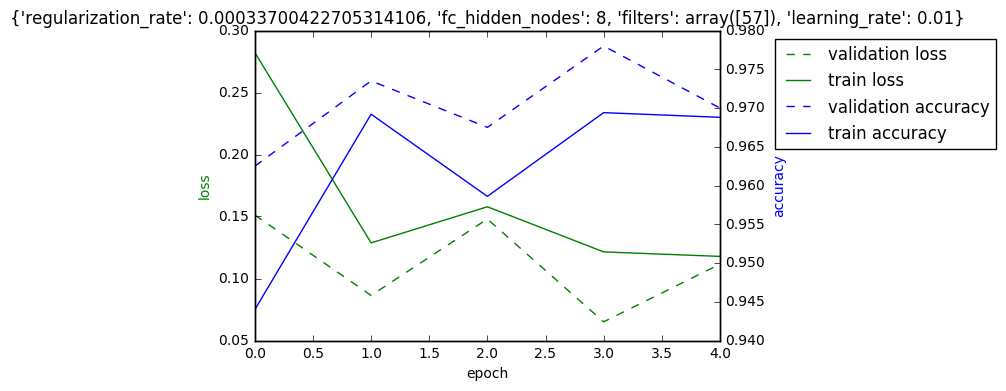

In [326]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [327]:
#%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,{'regularization_rate': 0.00033700422705314106...,0.9688,0.117823,0.97,0.111529


## Take the best current model 

In [328]:
best_model_index = np.argmax(val_accuracies)

In [329]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

0 CNN {'regularization_rate': 0.00033700422705314106, 'fc_hidden_nodes': 8, 'filters': array([57]), 'learning_rate': 0.01}


## Save the best current model

In [330]:
from keras.models import load_model

model_path = os.path.join('F:/CNN/notebooks/', 'Gtcg_010618_trimmed_dist_10purity_nosv')

best_model.save(model_path)

## Reload the best current model

In [331]:
import os
from keras.models import load_model
model_path = os.path.join('F:/CNN/notebooks/', 'Gtcg_010618_trimmed_dist_10purity_nosv')
model_reloaded = load_model(model_path)

## Inspect model predictions on test data

In [332]:
model = model_reloaded
datasize = X_test.shape[0]
probs = model.predict_proba(X_test[:datasize,:,:],batch_size=1)

## Columns are predicted, rows are truth

In [333]:
dict=mapclasses
dict_sorted = sorted(dict.items(), key=lambda x: x[1])
dict_sorted

[('INS_pos', 0), ('DEL_end', 1), ('DEL_start', 2), ('noSV', 3)]

In [334]:
labels = [i[0] for i in dict_sorted]

In [335]:
predicted = probs.argmax(axis=1)
y_index = y_test_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

,INS_pos,DEL_end,DEL_start,noSV
INS_pos,387,0,37,0
DEL_end,1,403,0,6
DEL_start,14,0,440,1
noSV,0,0,0,800


## Test best current model on testset

### Overall accuracy on the test set:

In [336]:
%%time
score_test = model_reloaded.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.11530752513199231, 0.97175682144566777]
Wall time: 1.92 s


### Re-check the train and validation scores: 

In [337]:
best_model.get_config()[0]

{'class_name': 'BatchNormalization',
 'config': {'axis': -1,
  'batch_input_shape': (None, 50, 18),
  'beta_constraint': None,
  'beta_initializer': {'class_name': 'Zeros', 'config': {}},
  'beta_regularizer': None,
  'center': True,
  'dtype': 'float32',
  'epsilon': 0.001,
  'gamma_constraint': None,
  'gamma_initializer': {'class_name': 'Ones', 'config': {}},
  'gamma_regularizer': None,
  'momentum': 0.99,
  'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}},
  'moving_variance_initializer': {'class_name': 'Ones', 'config': {}},
  'name': 'batch_normalization_166',
  'scale': True,
  'trainable': True}}

In [338]:
score_train = model_reloaded.evaluate(X_train, y_train_binary, verbose=False)
print('Train Score of best model: ' + str(score_train))

Train Score of best model: [0.10658843017816544, 0.97719999999999996]


In [339]:
score_val = model_reloaded.evaluate(X_val, y_val_binary, verbose=False)
print('Val Score of best model: ' + str(score_val))

Val Score of best model: [0.11152870109677315, 0.96999999999999997]
